<a href="https://colab.research.google.com/github/Ansalnakhan/PROJECT/blob/main/RUL%20PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting the drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir dataset
!cd dataset
!unzip /content/drive/MyDrive/naza.zip -d /content/dataset

Archive:  /content/drive/MyDrive/naza.zip
  inflating: /content/dataset/B0007.mat  
  inflating: /content/dataset/B0018.mat  
  inflating: /content/dataset/README.txt  
  inflating: /content/dataset/B0005.mat  
  inflating: /content/dataset/B0006.mat  


In [ ]:
#importing the necessary packages
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error,r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,TimeDistributed,LSTMCell
from tensorflow.keras.layers import Dropout,BatchNormalization,Bidirectional,MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model,Input

In [ ]:
#dataset preperation
def load_data(battery):
  mat = loadmat('./dataset/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]




In [ ]:
dataset_val, capacity_val = load_data('B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
data_train=dataset[(dataset['cycle']<90)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=90)]
data_set_test=data_test.iloc[:,1:2].values

from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
#created window of 10
for i in range(10,89):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


#LSTM

In [ ]:
model=Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.3))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200))
model.add(Dropout(0.3))
model.add(Dense(units=1))

In [ ]:
#optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 200)           161600    
                                                                 
 dropout (Dropout)           (None, 10, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_1 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_2 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               3

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 8s 127ms/step - loss: 0.1984 - root_mean_squared_error: 0.6299
Epoch 2/200
2/2 [==============================] - 0s 123ms/step - loss: 0.0998 - root_mean_squared_error: 0.4467
Epoch 3/200
2/2 [==============================] - 0s 116ms/step - loss: 0.0368 - root_mean_squared_error: 0.2714
Epoch 4/200
2/2 [==============================] - 0s 115ms/step - loss: 0.0275 - root_mean_squared_error: 0.2346
Epoch 5/200
2/2 [==============================] - 0s 114ms/step - loss: 0.0215 - root_mean_squared_error: 0.2073
Epoch 6/200
2/2 [==============================] - 0s 122ms/step - loss: 0.0383 - root_mean_squared_error: 0.2766
Epoch 7/200
2/2 [==============================] - 0s 115ms/step - loss: 0.0294 - root_mean_squared_error: 0.2424
Epoch 8/200
2/2 [==============================] - 0s 119ms/step - loss: 0.0142 - root_mean_squared_error: 0.1683
Epoch 9/200
2/2 [==============================] - 0s 122ms/step - loss: 0.0183 - root_m

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)


In [ ]:
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.020
Mean Absolute Error:  [0.01339936]
R2_score:  0.9323799718886222
    cycle  capacity  predicted       pre
89     90  1.605819   1.508456  1.508456
90     91  1.563849   1.504160  1.504160
91     92  1.548092   1.501157  1.501157
92     93  1.532376   1.498994  1.498994
93     94  1.526953   1.498131  1.498131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

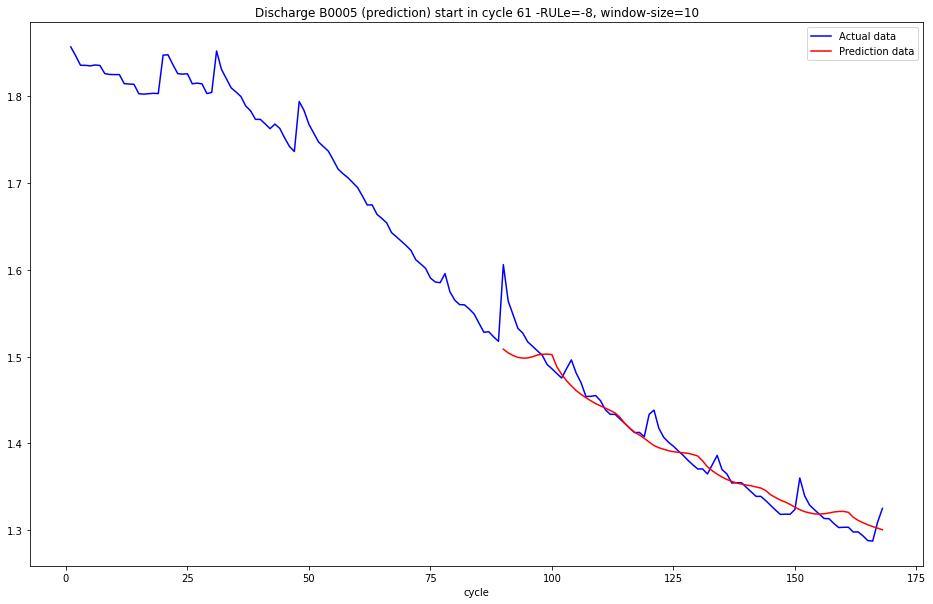

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
# #Draw threshold
# plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
# plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

# CNN-LSTM_DNN - Base

In [ ]:
model = Sequential()
#cnn with 64 neurons and kernel size 5 with padding and relu
model.add(Conv1D(64,5,padding="same",activation ="relu", input_shape=(X_train.shape[1],1)))
#lstm with same return sequences
model.add(LSTM(units=32,return_sequences=True))
model.add(LSTM(units=32,return_sequences=True))
model.add(Flatten())
#Fourth part DNN with 16 and 8 with relu activation
model.add(Dense(units=16,activation="relu"))
model.add(Dense(units=8,activation="relu"))
#final layer
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            384       
                                                                 
 lstm_4 (LSTM)               (None, 10, 32)            12416     
                                                                 
 lstm_5 (LSTM)               (None, 10, 32)            8320      
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                5136      
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 4s 17ms/step - loss: 0.2176 - root_mean_squared_error: 0.6597
Epoch 2/200
2/2 [==============================] - 0s 16ms/step - loss: 0.2113 - root_mean_squared_error: 0.6500
Epoch 3/200
2/2 [==============================] - 0s 16ms/step - loss: 0.2084 - root_mean_squared_error: 0.6455
Epoch 4/200
2/2 [==============================] - 0s 19ms/step - loss: 0.2053 - root_mean_squared_error: 0.6407
Epoch 5/200
2/2 [==============================] - 0s 16ms/step - loss: 0.2015 - root_mean_squared_error: 0.6349
Epoch 6/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1972 - root_mean_squared_error: 0.6280
Epoch 7/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1919 - root_mean_squared_error: 0.6195
Epoch 8/200
2/2 [==============================] - 0s 16ms/step - loss: 0.1858 - root_mean_squared_error: 0.6096
Epoch 9/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1779 - root_mean_squar

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.140
Mean Absolute Error:  [0.12246454]
R2_score:  -2.3487067466943183
    cycle  capacity  predicted       pre
89     90  1.605819   1.515603  1.508456
90     91  1.563849   1.515613  1.504160
91     92  1.548092   1.515539  1.501157
92     93  1.532376   1.515861  1.498994
93     94  1.526953   1.516243  1.498131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

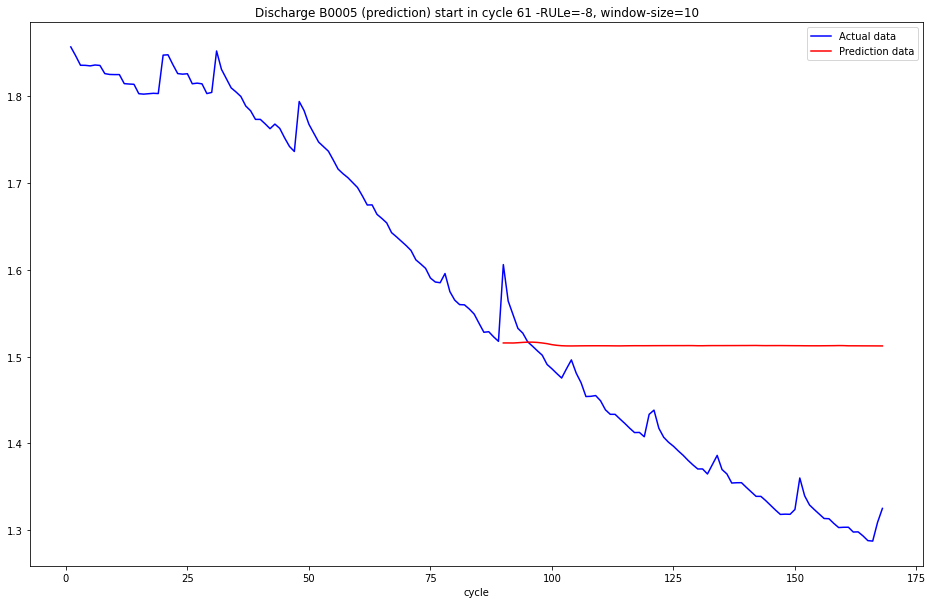

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
# plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
# plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

# lstm+conv

In [ ]:
model=Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200))
model.add(Dropout(0.3))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 200)           161600    
                                                                 
 dropout_4 (Dropout)         (None, 10, 200)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 32)            19232     
                                                                 
 lstm_7 (LSTM)               (None, 10, 200)           186400    
                                                                 
 dropout_5 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_8 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_6 (Dropout)         (None, 10, 200)          

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 8s 109ms/step - loss: 0.2030 - root_mean_squared_error: 0.6372
Epoch 2/200
2/2 [==============================] - 0s 105ms/step - loss: 0.1246 - root_mean_squared_error: 0.4992
Epoch 3/200
2/2 [==============================] - 0s 106ms/step - loss: 0.0403 - root_mean_squared_error: 0.2839
Epoch 4/200
2/2 [==============================] - 0s 111ms/step - loss: 0.0398 - root_mean_squared_error: 0.2823
Epoch 5/200
2/2 [==============================] - 0s 109ms/step - loss: 0.0215 - root_mean_squared_error: 0.2073
Epoch 6/200
2/2 [==============================] - 0s 114ms/step - loss: 0.0333 - root_mean_squared_error: 0.2579
Epoch 7/200
2/2 [==============================] - 0s 105ms/step - loss: 0.0255 - root_mean_squared_error: 0.2259
Epoch 8/200
2/2 [==============================] - 0s 116ms/step - loss: 0.0163 - root_mean_squared_error: 0.1806
Epoch 9/200
2/2 [==============================] - 0s 108ms/step - loss: 0.0212 - root_m

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.030
Mean Absolute Error:  [0.02564646]
R2_score:  0.8461124489591767
    cycle  capacity  predicted       pre
89     90  1.605819   1.514480  1.515603
90     91  1.563849   1.511029  1.515613
91     92  1.548092   1.508350  1.515539
92     93  1.532376   1.506130  1.515861
93     94  1.526953   1.504933  1.516243


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

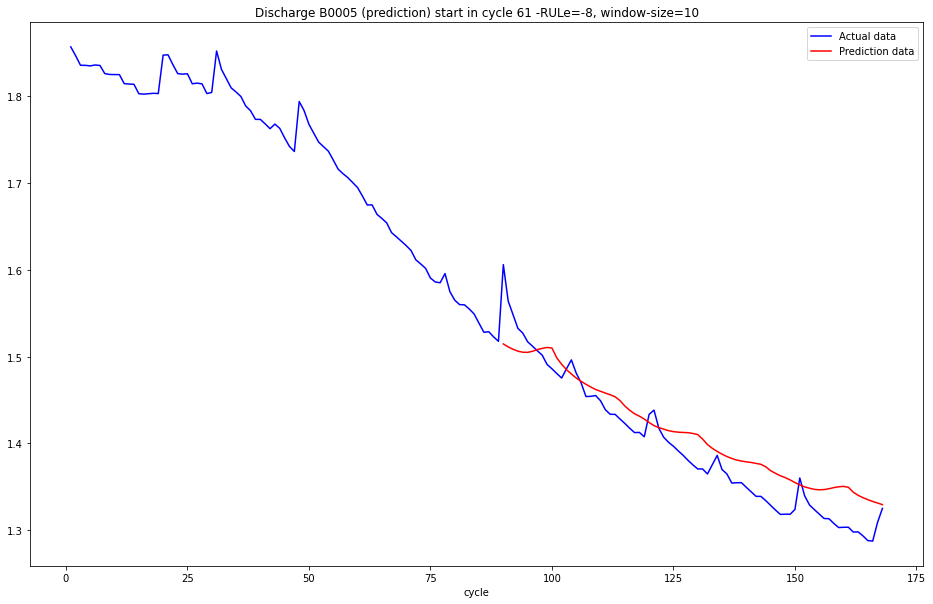

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
# plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
# plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

#lstm+cnn+bilstm

In [ ]:
model=Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Bidirectional(LSTM(units=200, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=200, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=200)))
model.add(Dropout(0.3))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 200)           161600    
                                                                 
 dropout_8 (Dropout)         (None, 10, 200)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 32)            19232     
                                                                 
 bidirectional (Bidirectiona  (None, 10, 400)          372800    
 l)                                                              
                                                                 
 dropout_9 (Dropout)         (None, 10, 400)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 400)          961600    
 nal)                                                 

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 13s 257ms/step - loss: 0.2001 - root_mean_squared_error: 0.6326
Epoch 2/200
2/2 [==============================] - 1s 234ms/step - loss: 0.0762 - root_mean_squared_error: 0.3904
Epoch 3/200
2/2 [==============================] - 1s 230ms/step - loss: 0.1261 - root_mean_squared_error: 0.5022
Epoch 4/200
2/2 [==============================] - 1s 241ms/step - loss: 0.0253 - root_mean_squared_error: 0.2250
Epoch 5/200
2/2 [==============================] - 1s 233ms/step - loss: 0.0630 - root_mean_squared_error: 0.3550
Epoch 6/200
2/2 [==============================] - 1s 230ms/step - loss: 0.0654 - root_mean_squared_error: 0.3616
Epoch 7/200
2/2 [==============================] - 1s 219ms/step - loss: 0.0452 - root_mean_squared_error: 0.3008
Epoch 8/200
2/2 [==============================] - 1s 228ms/step - loss: 0.0211 - root_mean_squared_error: 0.2055
Epoch 9/200
2/2 [==============================] - 1s 230ms/step - loss: 0.0246 - root_

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.026
Mean Absolute Error:  [0.02103208]
R2_score:  0.8875316769189908
    cycle  capacity  predicted       pre
89     90  1.605819   1.509248  1.514480
90     91  1.563849   1.507176  1.511029
91     92  1.548092   1.507150  1.508350
92     93  1.532376   1.507536  1.506130
93     94  1.526953   1.507844  1.504933


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

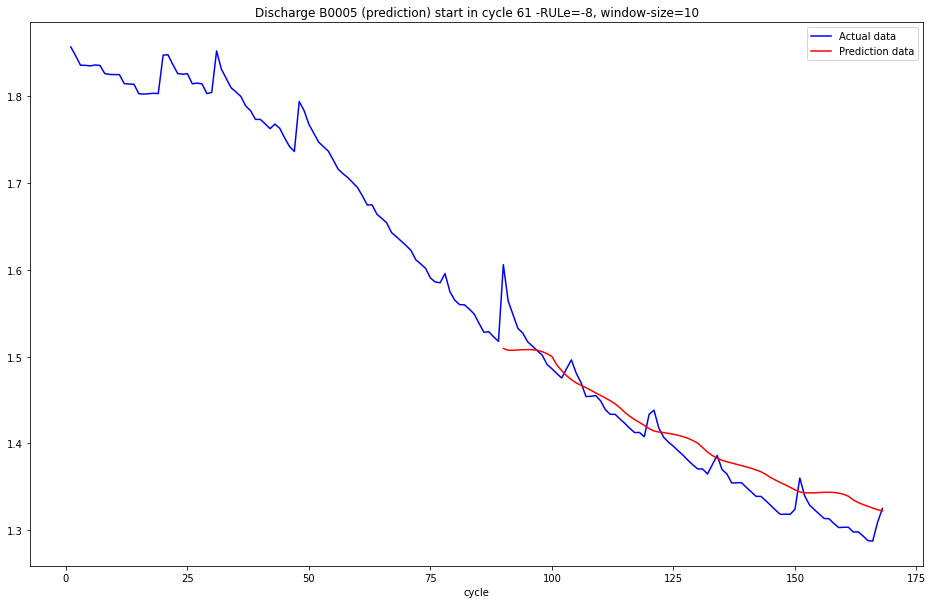

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
# plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
# plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

# Conv +lstm + conv

In [ ]:

model = Sequential()

model.add(Conv1D(64, 3,padding="same" ,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 10, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 64)            0         
 )                                                               
                                                                 
 lstm_14 (LSTM)              (None, 5, 100)            66000     
                                                                 
 dropout_12 (Dropout)        (None, 5, 100)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 5, 32)             9632      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 32)            0         
 1D)                                                  

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 2s 14ms/step - loss: 0.2054 - root_mean_squared_error: 0.6409
Epoch 2/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0987 - root_mean_squared_error: 0.4444
Epoch 3/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0306 - root_mean_squared_error: 0.2474
Epoch 4/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0061 - root_mean_squared_error: 0.1101
Epoch 5/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0228 - root_mean_squared_error: 0.2134
Epoch 6/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0293 - root_mean_squared_error: 0.2420
Epoch 7/200
2/2 [==============================] - 0s 13ms/step - loss: 0.0197 - root_mean_squared_error: 0.1985
Epoch 8/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0068 - root_mean_squared_error: 0.1164
Epoch 9/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0058 - root_mean_squar

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.021
Mean Absolute Error:  [0.01583411]
R2_score:  0.9258904205995478
    cycle  capacity  predicted       pre
89     90  1.605819   1.510574  1.509248
90     91  1.563849   1.510059  1.507176
91     92  1.548092   1.512735  1.507150
92     93  1.532376   1.512580  1.507536
93     94  1.526953   1.512135  1.507844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

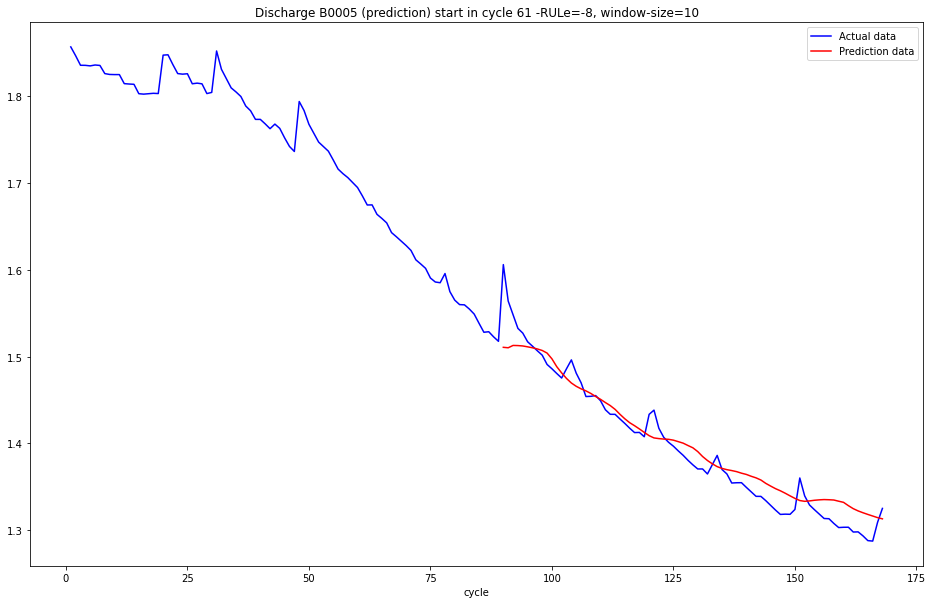

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
# plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
# plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

# Conv +lstm + conv + dnn

In [ ]:
model = Sequential()

model.add(Conv1D(64, 3,padding="same" ,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=16))
model.add(Dense(units=8))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 10, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 5, 100)            66000     
                                                                 
 dropout_13 (Dropout)        (None, 5, 100)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 5, 32)             9632      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 32)            0         
 1D)                                                  

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 2s 14ms/step - loss: 0.1447 - root_mean_squared_error: 0.5380
Epoch 2/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0421 - root_mean_squared_error: 0.2901
Epoch 3/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0082 - root_mean_squared_error: 0.1284
Epoch 4/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0346 - root_mean_squared_error: 0.2630
Epoch 5/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0287 - root_mean_squared_error: 0.2397
Epoch 6/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0091 - root_mean_squared_error: 0.1350
Epoch 7/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0070 - root_mean_squared_error: 0.1185
Epoch 8/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0105 - root_mean_squared_error: 0.1446
Epoch 9/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0156 - root_mean_squar

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.025
Mean Absolute Error:  [0.02070274]
R2_score:  0.8901557202431045
    cycle  capacity  predicted       pre
89     90  1.605819   1.510745  1.510574
90     91  1.563849   1.509820  1.510059
91     92  1.548092   1.509258  1.512735
92     93  1.532376   1.508330  1.512580
93     94  1.526953   1.509088  1.512135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

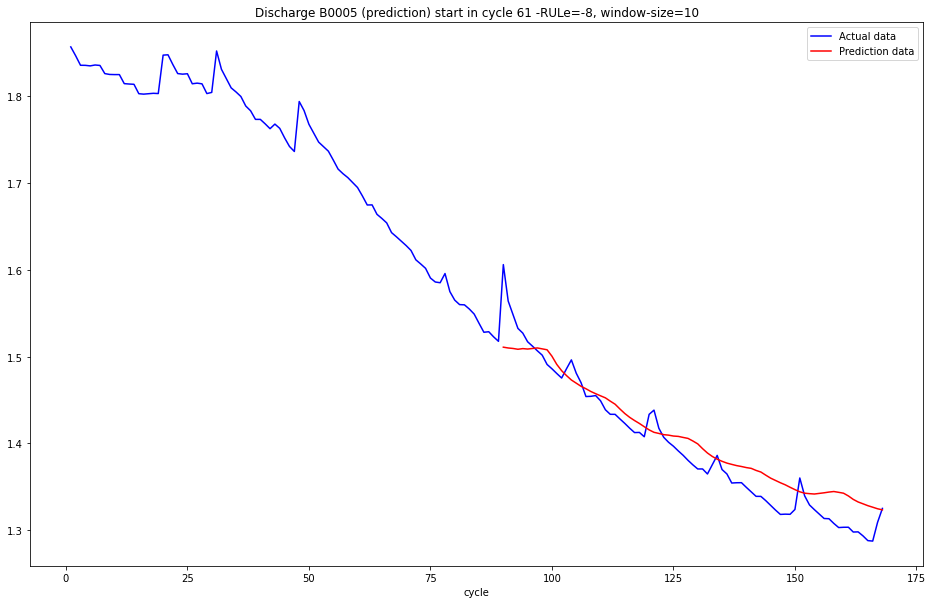

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
# plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
# plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

#CNN_LSTM_DNN

In [ ]:
model = Sequential()
#cnn with 64 neurons and kernel size 5 with padding and relu
model.add(Conv1D(64,5,padding="same",input_shape=(X_train.shape[1],1)))
#lstm with same return sequences
model.add(LSTM(units=32,return_sequences=True))
model.add(LSTM(units=32,return_sequences=True))
model.add(Flatten())
#Fourth part DNN with 16 and 8 with relu activation
model.add(Dense(units=16))
model.add(Dense(units=8))
#final layer
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 10, 64)            384       
                                                                 
 lstm_16 (LSTM)              (None, 10, 32)            12416     
                                                                 
 lstm_17 (LSTM)              (None, 10, 32)            8320      
                                                                 
 flatten_3 (Flatten)         (None, 320)               0         
                                                                 
 dense_10 (Dense)            (None, 16)                5136      
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 1)                

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 4s 15ms/step - loss: 0.1719 - root_mean_squared_error: 0.5864
Epoch 2/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0770 - root_mean_squared_error: 0.3923
Epoch 3/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0189 - root_mean_squared_error: 0.1944
Epoch 4/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0139 - root_mean_squared_error: 0.1668
Epoch 5/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0313 - root_mean_squared_error: 0.2501
Epoch 6/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0207 - root_mean_squared_error: 0.2032
Epoch 7/200
2/2 [==============================] - 0s 14ms/step - loss: 0.0074 - root_mean_squared_error: 0.1215
Epoch 8/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0084 - root_mean_squared_error: 0.1298
Epoch 9/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0136 - root_mean_squar

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.045
Mean Absolute Error:  [0.03831736]
R2_score:  0.6507208770429901
    cycle  capacity  predicted       pre
89     90  1.605819   1.514630  1.510745
90     91  1.563849   1.515035  1.509820
91     92  1.548092   1.515615  1.509258
92     93  1.532376   1.516367  1.508330
93     94  1.526953   1.516806  1.509088


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

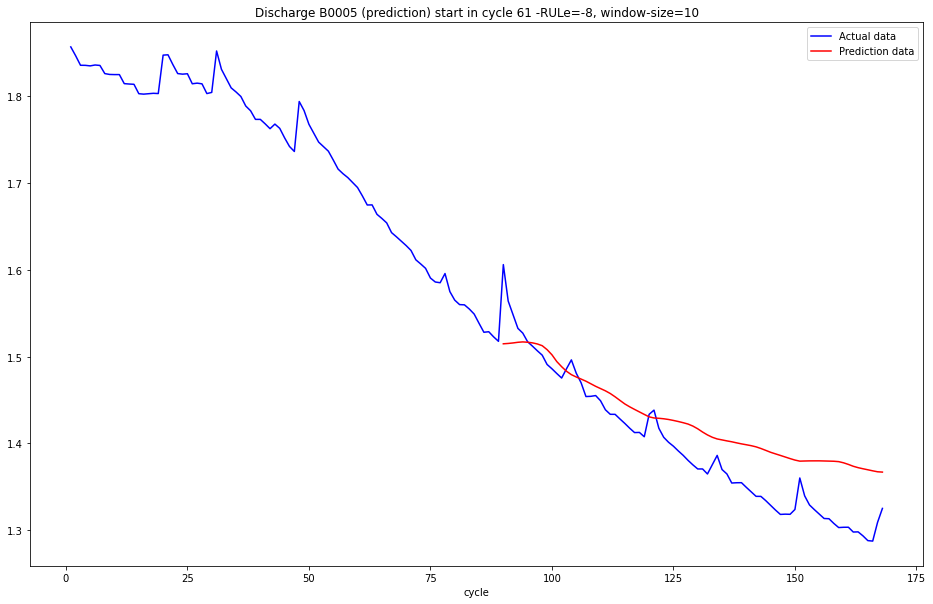

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
# plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
# plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

#cnn+bilstm+dnn

In [ ]:
model = Sequential()

model.add(Conv1D(64, 3,padding="same" ,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=16))
model.add(Dense(units=8))
model.add(Dense(units=1))
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 10, 64)            256       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 5, 200)           132000    
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 5, 200)            0         
                                                                 
 flatten_4 (Flatten)         (None, 1000)              0         
                                                                 
 dense_13 (Dense)            (None, 16)               

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=50)

Epoch 1/200
2/2 [==============================] - 4s 29ms/step - loss: 0.1565 - root_mean_squared_error: 0.5595
Epoch 2/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0178 - root_mean_squared_error: 0.1885
Epoch 3/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0257 - root_mean_squared_error: 0.2268
Epoch 4/200
2/2 [==============================] - 0s 15ms/step - loss: 0.0396 - root_mean_squared_error: 0.2815
Epoch 5/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0134 - root_mean_squared_error: 0.1639
Epoch 6/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0043 - root_mean_squared_error: 0.0926
Epoch 7/200
2/2 [==============================] - 0s 16ms/step - loss: 0.0103 - root_mean_squared_error: 0.1436
Epoch 8/200
2/2 [==============================] - 0s 18ms/step - loss: 0.0163 - root_mean_squared_error: 0.1806
Epoch 9/200
2/2 [==============================] - 0s 17ms/step - loss: 0.0146 - root_mean_squar

In [ ]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=model.predict(X_test)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

(79, 10)
Test RMSE: 0.034
Mean Absolute Error:  [0.02821896]
R2_score:  0.8050952667406605
    cycle  capacity  predicted       pre
89     90  1.605819   1.508943  1.514630
90     91  1.563849   1.528499  1.515035
91     92  1.548092   1.536427  1.515615
92     93  1.532376   1.524653  1.516367
93     94  1.526953   1.523672  1.516806


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')

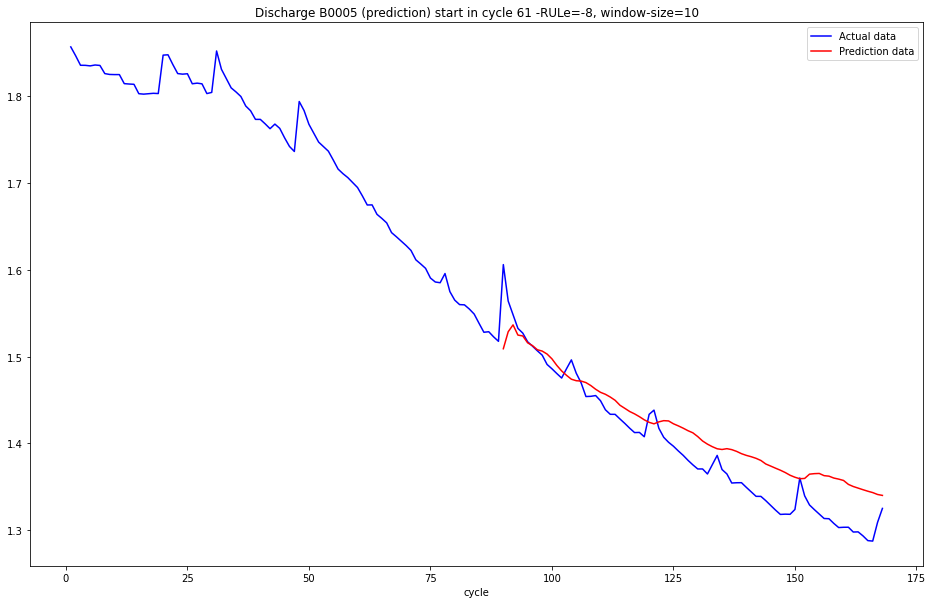

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
# plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
# plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 61 -RULe=-8, window-size=10')